In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
filepath="./dataset"
df = pd.read_csv(r'./GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)
labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [3]:
df['image'] = filepath+"/images/"+df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

                               image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ./dataset/images/ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ./dataset/images/ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ./dataset/images/ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ./dataset/images/ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ./dataset/images/ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [4]:
labels     =['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list =[]
for i in range (len(df)):
    row = list(df.iloc[i])
    del row[0]
    index = np.argmax(row)
    label = labels[index]
    label_list.append(label)
df['label'] = label_list
df=df.drop(labels, axis=1)
print (df.head())

                               image label
0  ./dataset/images/ISIC_0024306.jpg    NV
1  ./dataset/images/ISIC_0024307.jpg    NV
2  ./dataset/images/ISIC_0024308.jpg    NV
3  ./dataset/images/ISIC_0024309.jpg    NV
4  ./dataset/images/ISIC_0024310.jpg   MEL


In [5]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,rescale = 1./255,
        x_col='image',
        y_col='label',
        target_size=(150,150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,rescale = 1./255,
        x_col='image',
        y_col='label',
        target_size=(150,150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, 
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,rescale = 1./255,
        x_col='image',
        y_col='label',
        target_size=(150,150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [6]:
train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)


In [7]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 6309 validated image filenames belonging to 7 classes.
Found 701 validated image filenames belonging to 7 classes.
Found 3005 validated image filenames belonging to 7 classes.


In [8]:
model2=Sequential()
mdl = DenseNet121(input_shape=(150,150,3), 
                         include_top=False,
                         weights="imagenet")
for layer in mdl.layers:
    layer.trainable=False
model2.add(mdl)
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(2048,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1024,kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(7,activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              33556480  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [9]:
OPT    = Adam(learning_rate=0.001)

model2.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [10]:
history = model2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=15,
)
model2.save('cl.h5')

Epoch 1/15
198/198 [==============================] - 385s 2s/step - loss: 1.0821 - accuracy: 0.6673 - val_loss: 0.8924 - val_accuracy: 0.6876
Epoch 2/15
198/198 [==============================] - 351s 2s/step - loss: 0.7133 - accuracy: 0.7561 - val_loss: 0.6773 - val_accuracy: 0.7646
Epoch 3/15
198/198 [==============================] - 344s 2s/step - loss: 0.5900 - accuracy: 0.7865 - val_loss: 0.6497 - val_accuracy: 0.7618
Epoch 4/15
198/198 [==============================] - 353s 2s/step - loss: 0.5010 - accuracy: 0.8150 - val_loss: 0.6655 - val_accuracy: 0.7703
Epoch 5/15
198/198 [==============================] - 408s 2s/step - loss: 0.4405 - accuracy: 0.8382 - val_loss: 0.6156 - val_accuracy: 0.7732
Epoch 6/15
198/198 [==============================] - 427s 2s/step - loss: 0.3862 - accuracy: 0.8567 - val_loss: 0.6497 - val_accuracy: 0.7689
Epoch 7/15
198/198 [==============================] - 379s 2s/step - loss: 0.3501 - accuracy: 0.8697 - val_loss: 0.7072 - val_accuracy: 0.7817

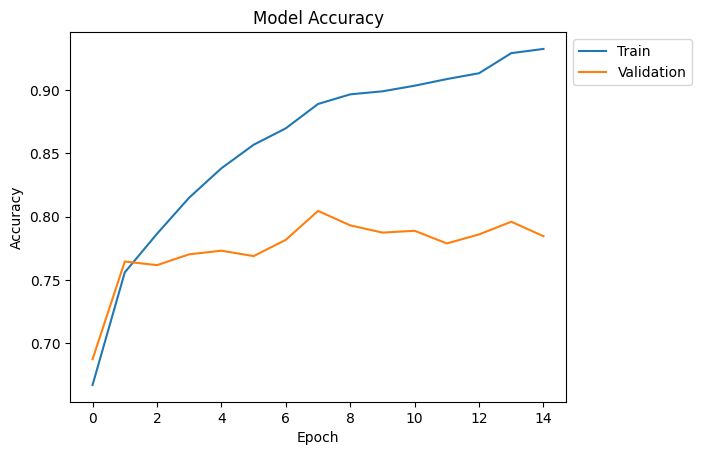

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

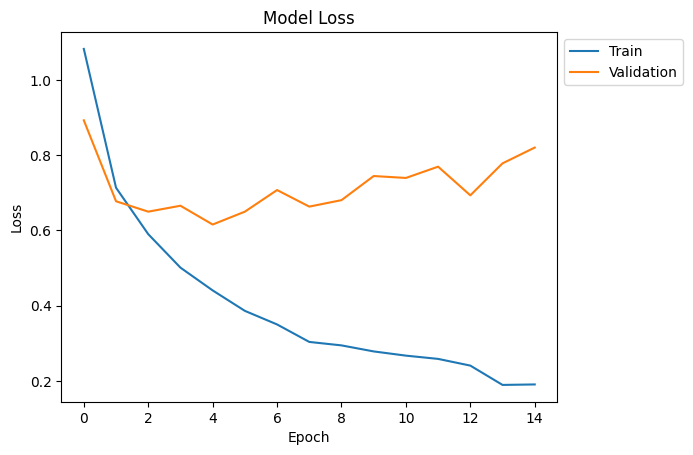

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
model=load_model('cl.h5')
labels=['Melanoma', 'elanocytic nevi', 'Basal cell carcinoma', 'Actinic keratoses', 'Benign keratosis-like lesions', 'Dermatofibroma', 'vascular lesions']


1/1 [==============================] - 0s 133ms/step
The image is of skin disease of class : Basal cell carcinoma


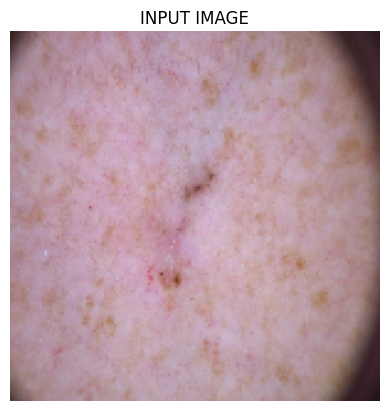

In [20]:
image_path="./dataset/images/ISIC_0024360.jpg"
img = load_img(image_path, target_size=(150,150,3))
img = img_to_array(img)
img=img/255
plt.imshow(img)
plt.axis("off")
img = np.expand_dims(img, axis=0)
result=np.argmax(model.predict(img))
label=labels[result]
print("The image is of skin disease of class : "+ label)
plt.title("INPUT IMAGE")
plt.show()

1/1 [==============================] - 0s 127ms/step
The image is of skin disease of class : Basal cell carcinoma


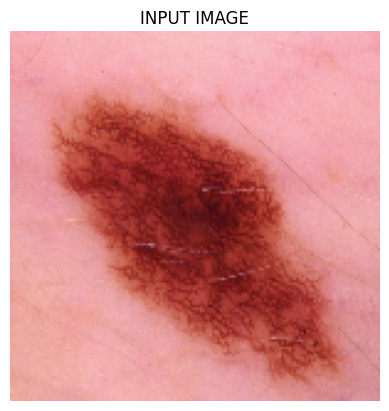

In [19]:
image_path="./dataset/images/ISIC_0024308.jpg"
img = load_img(image_path, target_size=(150,150,3))
img = img_to_array(img)
img=img/255
plt.imshow(img)
plt.axis("off")
img = np.expand_dims(img, axis=0)
result=np.argmax(model.predict(img))
label=labels[result]
print("The image is of skin disease of class : "+ label)
plt.title("INPUT IMAGE")
plt.show()